# 03_sentiment_analysis_vader.ipynb

## Objectif du notebook

- Appliquer le modèle **VADER (NLTK)** sur les 5936 avis.
- VADER est particulièrement adapté aux avis touristiques courts, incluant :
  - émoticônes
  - majuscules
  - ponctuation expressive
  - négations complexes
- Ajouter les colonnes suivantes :
  - `sentiment_vader` (Positif / Négatif / Neutre)
  - `score_vader` (score compound entre -1 et +1)
- Comparer de manière claire la répartition des sentiments entre :
  - Avis réels (963)
  - Avis synthétiques Groq (5000)

---

Ce notebook constitue l’étape d’analyse de sentiment du projet et permettra d’inclure une comparaison essentielle pour la soutenance et le rapport.


In [1]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Téléchargement une seule fois (à lancer la première fois)
nltk.download('vader_lexicon', quiet=True)

# Style des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
colors_real = '#FF6B6B'      # rouge corail → avis réels
colors_synth = '#4ECDC4'     # turquoise → avis Groq

print("Chargement et application de VADER en cours...\n")

Chargement et application de VADER en cours...



In [2]:
# =============================================================================
# 1. CHARGEMENT DU DATASET NETTOYÉ
# =============================================================================

# Chemin exact vers ton fichier final
path = r"../Data/Real and synthetic/pokhara_reviews_final_clean.csv"

df = pd.read_csv(path)

print(f"Dataset chargé : {df.shape[0]} avis, {df.shape[1]} colonnes")
print(f"Réels : {(df['source'] == 'real').sum()} | Synthétiques Groq : {(df['source'] == 'synthetic_groq').sum()}\n")

Dataset chargé : 5936 avis, 15 colonnes
Réels : 936 | Synthétiques Groq : 5000



In [3]:
# =============================================================================
# 2. INITIALISATION DE VADER
# =============================================================================

sid = SentimentIntensityAnalyzer()
print("VADER initialisé avec succès")

VADER initialisé avec succès


In [4]:
# =============================================================================
# 3. FONCTION D'ANALYSE DE SENTIMENT
# =============================================================================

def analyze_sentiment_vader(text):
    """
    Retourne le sentiment et le score compound avec VADER
    Seuil classique :
        compound >= 0.05  → Positif
        compound <= -0.05 → Négatif
        sinon             → Neutre
    """
    if pd.isna(text):
        return "Neutre", 0.0
    
    scores = sid.polarity_scores(str(text))
    compound = scores['compound']
    
    if compound >= 0.05:
        sentiment = "Positif"
    elif compound <= -0.05:
        sentiment = "Négatif"
    else:
        sentiment = "Neutre"
        
    return sentiment, round(compound, 4)

# Test rapide sur un avis
test = df['review_clean'].iloc[0]
print(f"Exemple d'avis :\n{test[:200]}...\n")
sent, score = analyze_sentiment_vader(test)
print(f"→ Sentiment VADER : {sent} (score = {score})\n")

Exemple d'avis :
Amazing place to chill out. Nice restaurants near lakeside where you can sit ,have beer and snacks with lakeside view. You can also take boat rides on hourly charges. There's a temple also few meters ...

→ Sentiment VADER : Positif (score = 0.9468)



In [5]:
# =============================================================================
# 4. APPLICATION SUR TOUT LE DATASET (environ 30-60 secondes)
# =============================================================================

print("Application de VADER sur les 5936 avis... (patience)")

# On applique uniquement sur review_clean pour éviter les artefacts
results = df['review_clean'].apply(analyze_sentiment_vader)

df['sentiment_vader'] = [r[0] for r in results]
df['score_vader']     = [r[1] for r in results]

print("Analyse VADER terminée !\n")
print(df[['review_clean', 'sentiment_vader', 'score_vader']].head(3))

Application de VADER sur les 5936 avis... (patience)
Analyse VADER terminée !

                                        review_clean sentiment_vader  \
0  Amazing place to chill out. Nice restaurants n...         Positif   
1  Best place in Pokhara to enjoy any time of the...         Positif   
2  Enjoying boating with awesome scene of nature,...         Positif   

   score_vader  
0       0.9468  
1       0.9456  
2       0.9136  


RÉPARTITION GLOBALE DES SENTIMENTS (VADER)
sentiment_vader
Neutre      3.61
Négatif    17.39
Positif    79.01
Name: proportion, dtype: float64

COMPARAISON RÉEL vs SYNTHÉTIQUE
sentiment_vader     Positif  Neutre  Négatif
source_clean                                
Réel                  89.85    7.69     2.46
Synthétique (Groq)    76.98    2.84    20.18



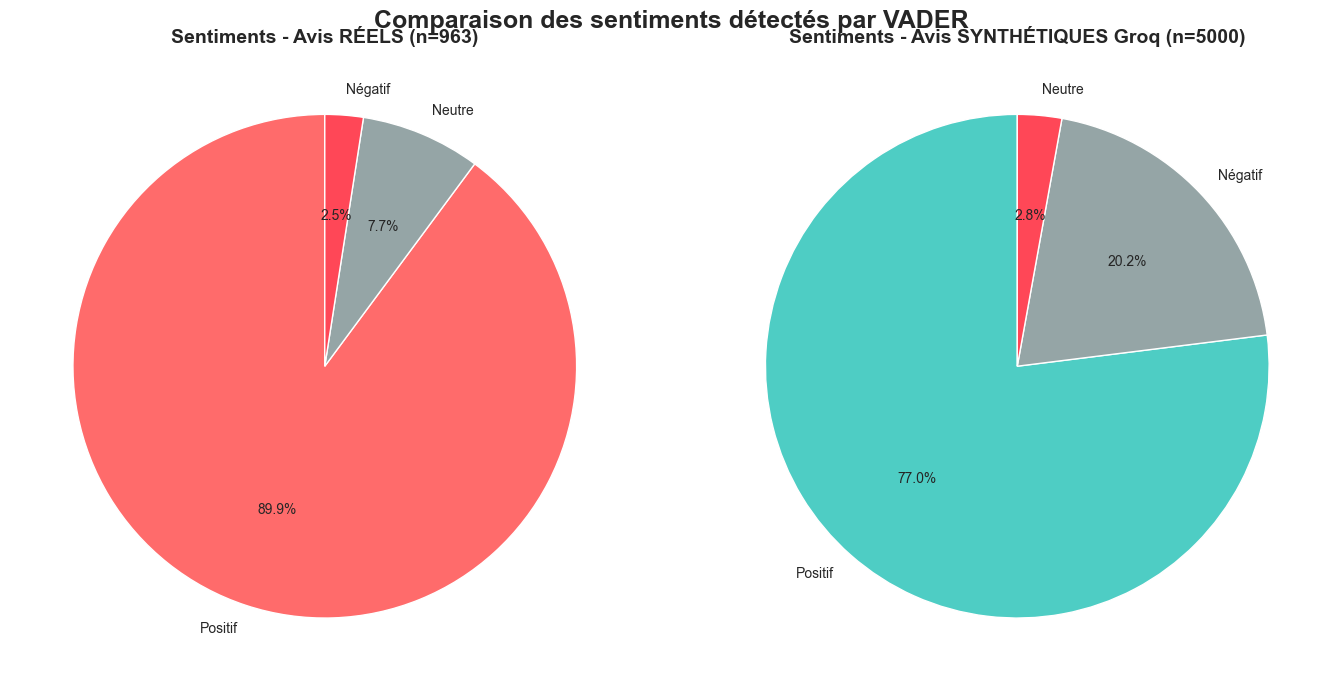

In [7]:
# =============================================================================
# 5. RÉSULTATS GLOBAUX
# =============================================================================

print("RÉPARTITION GLOBALE DES SENTIMENTS (VADER)\n" + "="*60)

global_dist = df['sentiment_vader'].value_counts(normalize=True).round(4) * 100
print(global_dist.sort_index())
print()

# Tableau comparatif Réel vs Synthétique (LE TABLEAU QUI VA FAIRE LA DIFFÉRENCE À LA SOUTENANCE)
print("COMPARAISON RÉEL vs SYNTHÉTIQUE\n" + "="*60)
comparison = pd.crosstab(
    df['source_clean' if 'source_clean' in df.columns else df['source'].map({'real':'Réel','synthetic_groq':'Synthétique (Groq)'})],
    df['sentiment_vader'],
    normalize='index'
).round(4) * 100

# Réordonnancement des colonnes
comparison = comparison[['Positif', 'Neutre', 'Négatif']]
print(comparison)
print()

# Graphique camembert comparatif
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Réels
real_data = df[df['source'] == 'real']['sentiment_vader'].value_counts()
axes[0].pie(real_data.values, labels=real_data.index, autopct='%1.1f%%',
            colors=[colors_real, '#95A5A6', '#FF4757'], startangle=90)
axes[0].set_title('Sentiments - Avis RÉELS (n=963)', fontsize=14, fontweight='bold')

# Synthétiques
synth_data = df[df['source'] == 'synthetic_groq']['sentiment_vader'].value_counts()
axes[1].pie(synth_data.values, labels=synth_data.index, autopct='%1.1f%%',
            colors=[colors_synth, '#95A5A6', '#FF4757'], startangle=90)
axes[1].set_title('Sentiments - Avis SYNTHÉTIQUES Groq (n=5000)', fontsize=14, fontweight='bold')

plt.suptitle('Comparaison des sentiments détectés par VADER', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()



In [11]:
# =============================================================================
# 6. EXEMPLES D'AVIS PAR SENTIMENT
# =============================================================================

print("EXEMPLES REPRÉSENTATIFS PAR SENTIMENT\n" + "="*60)

for sentiment in ['Positif', 'Négatif', 'Neutre']:
    print(f"\n{sentiment.upper()} (Réel) :")
    sample_real = df[(df['source'] == 'real') & (df['sentiment_vader'] == sentiment)]['review_clean']
    if len(sample_real) > 0:
        print("→", sample_real.sample(1).values[0][:300])
    else:
        print("   Aucun avis réel dans cette catégorie")
        
    print(f"{sentiment.upper()} (Synthétique Groq) :")
    sample_synth = df[(df['source'] == 'synthetic_groq') & (df['sentiment_vader'] == sentiment)]['review_clean']
    if len(sample_synth) > 0:
        print("→", sample_synth.sample(1).values[0][:300])
    else:
        print("   Aucun avis synthétique dans cette catégorie")
    print("-"*60)

EXEMPLES REPRÉSENTATIFS PAR SENTIMENT

POSITIF (Réel) :
→ nice place, boats can be good
POSITIF (Synthétique Groq) :
→ Pokhara is okay, I mean it's not bad, but it's not amazing either. The Himalayan views are nice, I guess.
------------------------------------------------------------

NÉGATIF (Réel) :
→ The last time I visited Pokhara was in 1988! so it's obviously changed a lot and perhaps not all for the better. Many hotels and restaurants have sprung up with no doubt more to come to cater for expected higher number of visitors once the …
NÉGATIF (Synthétique Groq) :
→ I was disappointed with the paragliding experience in Pokhara. The instructors seemed rushed, and the equipment was old.
------------------------------------------------------------

NEUTRE (Réel) :
→ This lake - Fewa is the heart of Pokhara, around which all the touristic establishments thrives.
NEUTRE (Synthétique Groq) :
→ I was looking forward to trying paragliding, but the weather was too cloudy. Maybe next time,

In [13]:
# =============================================================================
# 7. SAUVEGARDE DU DATASET ENRICHI AVEC VADER
# =============================================================================

output_path = r"../Data/Real and synthetic/pokhara_reviews_with_vader.csv"

df.to_csv(output_path, index=False, encoding='utf-8')
print(f"Dataset enrichi avec VADER sauvegardé :\n   {output_path}")
print(f"Colonnes ajoutées : sentiment_vader, score_vader")
print(f"Prochain notebook → Hugging Face RoBERTa (encore plus précis !)")

Dataset enrichi avec VADER sauvegardé :
   ../Data/Real and synthetic/pokhara_reviews_with_vader.csv
Colonnes ajoutées : sentiment_vader, score_vader
Prochain notebook → Hugging Face RoBERTa (encore plus précis !)
